# Stats

By Alejandro Fernández Sánchez

## Initialization

In [1]:
from typing import Any
from neo4j import GraphDatabase, basic_auth, Driver
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
load_dotenv()

True

In [3]:
DB_HOST = os.getenv("NEO4J_HOST")
DB_PORT = os.getenv("NEO4J_PORT")
DB_USER = os.getenv("NEO4J_USER")
DB_PASS = os.getenv("NEO4J_PASS")
LAST_FM_API_KEY = os.getenv("LAST_FM_API_KEY")

# .env validation
assert DB_HOST is not None and \
    DB_PORT is not None and \
    DB_USER is not None and \
    DB_PASS is not None and \
    LAST_FM_API_KEY is not None, \
    "INVALID .env"

In [4]:
driver = GraphDatabase.driver(f"bolt://{DB_HOST}:{DB_PORT}", auth=basic_auth(DB_USER, DB_PASS))
driver

In [5]:
def execute_query_return(driver: Driver, query: str, params: None | dict[str, Any] = None) -> list[dict[str, Any]]:
    with driver.session() as session:
        result = session.run(query, params)  # type: ignore
        return result.data()

## Data obtention

### Artist

#### Counts

In [6]:
# Artist count
query = "match (n:Artist) return count(n) as c;"
total_artist_count = execute_query_return(driver, query)[0]["c"]
total_artist_count

810337

In [7]:
# Artists processed
query = "match (n:Artist {last_fm_call: true}) return count(n) as c;" 
artists_processed = execute_query_return(driver, query)[0]["c"]
print("artists_processed:", artists_processed)
print(f"{artists_processed / total_artist_count * 100:.2f}%")

artists_processed: 208431
25.72%


In [8]:
# Artists processed and in lastfm
query = "match (n:Artist {last_fm_call: true, in_last_fm: true}) return count(n) as c;" 
artists_in_lastfm = execute_query_return(driver, query)[0]["c"]
print("artists_in_lastfm:", artists_in_lastfm)
print(f"{artists_in_lastfm / artists_processed * 100:.2f}%")

artists_in_lastfm: 199135
95.54%


#### Listeners

In [9]:
# Listeners
query = "match (n:Artist {last_fm_call: true, in_last_fm: true}) return n.listeners as l;" 
listeners = sorted([artist["l"] for artist in execute_query_return(driver, query)])
listeners = np.array(listeners)
log_listeners = np.where(listeners > 0, np.log(listeners) + 1, listeners)

/tmp/ipykernel_4679/4158318754.py:5: RuntimeWarning: divide by zero encountered in log
  log_listeners = np.where(listeners > 0, np.log(listeners) + 1, listeners)


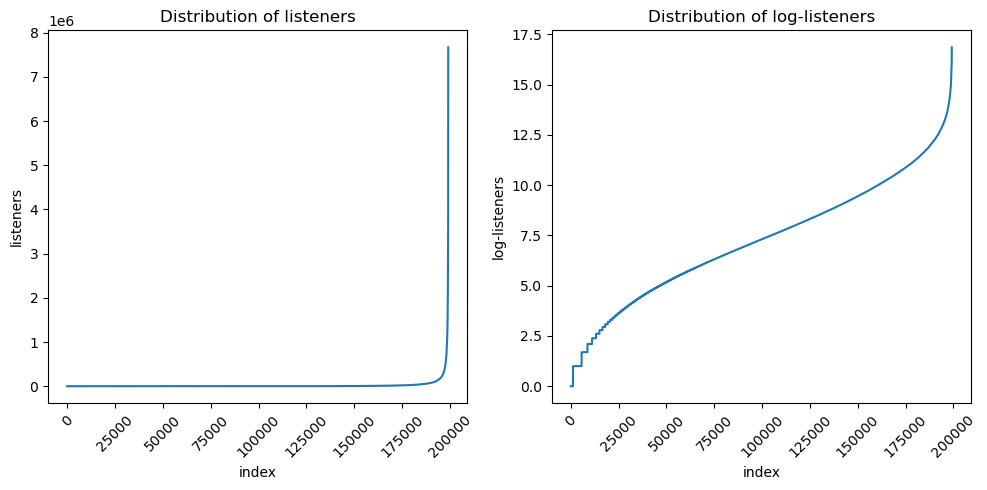

In [10]:
# Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(listeners)
ax1.set_title('Distribution of listeners')
ax1.set_xlabel('index')
ax1.set_ylabel('listeners')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(log_listeners)
ax2.set_title('Distribution of log-listeners')
ax2.set_xlabel('index')
ax2.set_ylabel('log-listeners')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/distr_listeners.png")
plt.show()

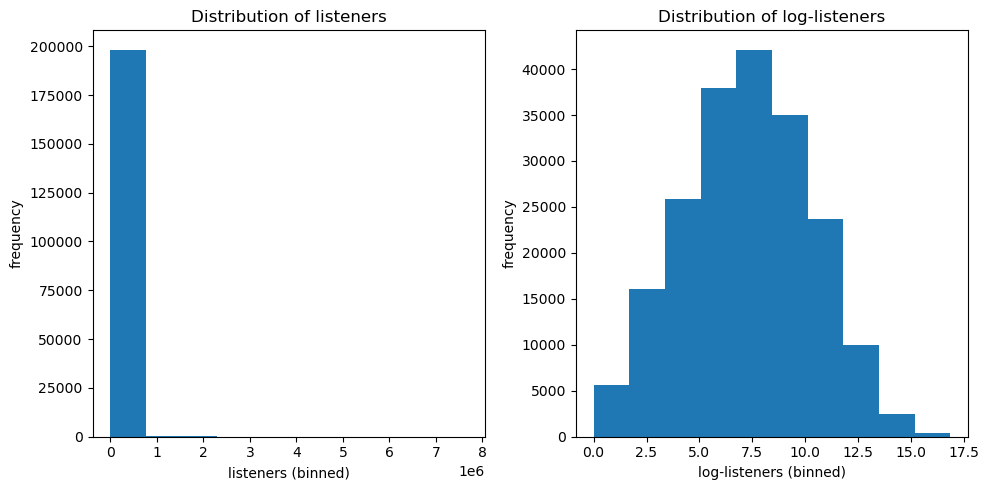

In [11]:
num_bins = 10

listeners_hist, listeners_bins = np.histogram(listeners, bins=num_bins)
log_listeners_hist, log_listeners_bins = np.histogram(log_listeners, bins=num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(listeners_bins[:-1], listeners_hist, width=np.diff(listeners_bins), align='edge')
ax1.set_title('Distribution of listeners')
ax1.set_xlabel('listeners (binned)')
ax1.set_ylabel('frequency')

ax2.bar(log_listeners_bins[:-1], log_listeners_hist, width=np.diff(log_listeners_bins), align='edge')
ax2.set_title('Distribution of log-listeners')
ax2.set_xlabel('log-listeners (binned)')
ax2.set_ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_listeners.png')
plt.show()

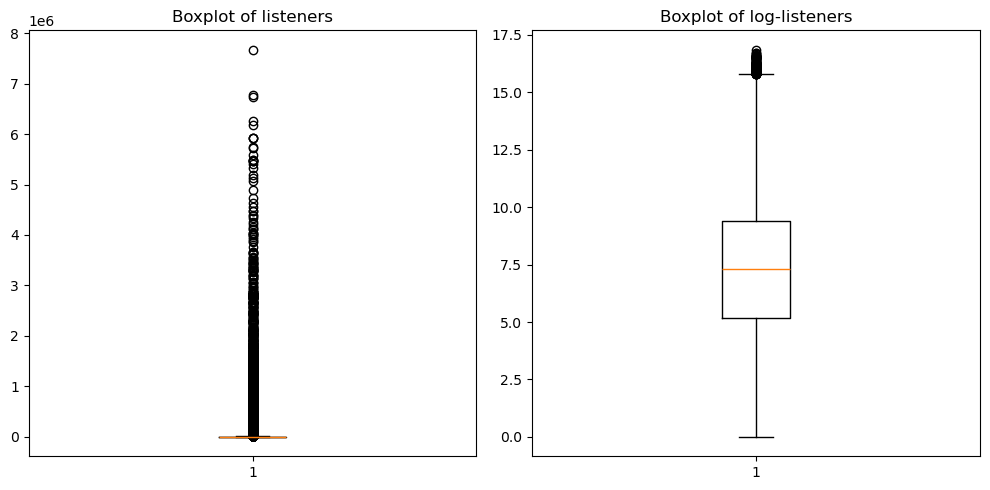

In [12]:
# Boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.boxplot(listeners)
ax1.set_title('Boxplot of listeners')

ax2.boxplot(log_listeners)
ax2.set_title('Boxplot of log-listeners')

plt.tight_layout()
plt.savefig("./img/boxplots_listeners.png")
plt.show()

In [13]:
# Stats
print("Listeners")
print(f"   Min: {np.min(listeners)}")
print(f"   Max: {np.max(listeners)}")
print(f"  Mean: {np.mean(listeners):.2f}")
print(f"    SD: {np.std(listeners):.2f}")
print(f"    Q1: {np.percentile(listeners, 25):.2f}")
print(f"    Q2: {np.percentile(listeners, 50):.2f}")
print(f"    Q3: {np.percentile(listeners, 75):.2f}")

print()

print("Log-Listeners")
print(f"  Mean: {np.mean(log_listeners):.2f}")
print(f"    SD: {np.std(log_listeners):.2f}")
print(f"   Min: {np.min(log_listeners)}")
print(f"    Q1: {np.percentile(log_listeners, 25):.2f}")
print(f"    Q2: {np.percentile(log_listeners, 50):.2f}")
print(f"    Q3: {np.percentile(log_listeners, 75):.2f}")
print(f"   Max: {np.max(log_listeners)}")

Listeners
   Min: 0
   Max: 7670372
  Mean: 20558.85
    SD: 139579.57
    Q1: 64.00
    Q2: 543.00
    Q3: 4509.00

Log-Listeners
  Mean: 7.26
    SD: 3.01
   Min: 0.0
    Q1: 5.16
    Q2: 7.30
    Q3: 9.41
   Max: 16.85287567281921


#### Playcount

In [14]:
# Playcount
query = "match (n:Artist {last_fm_call: true, in_last_fm: true}) return n.playcount as p;" 
playcount = sorted([artist["p"] for artist in execute_query_return(driver, query)])
playcount = np.array(playcount)
log_playcount = np.where(playcount > 0, np.log(playcount) + 1, playcount)

/tmp/ipykernel_4679/3239605293.py:5: RuntimeWarning: divide by zero encountered in log
  log_playcount = np.where(playcount > 0, np.log(playcount) + 1, playcount)


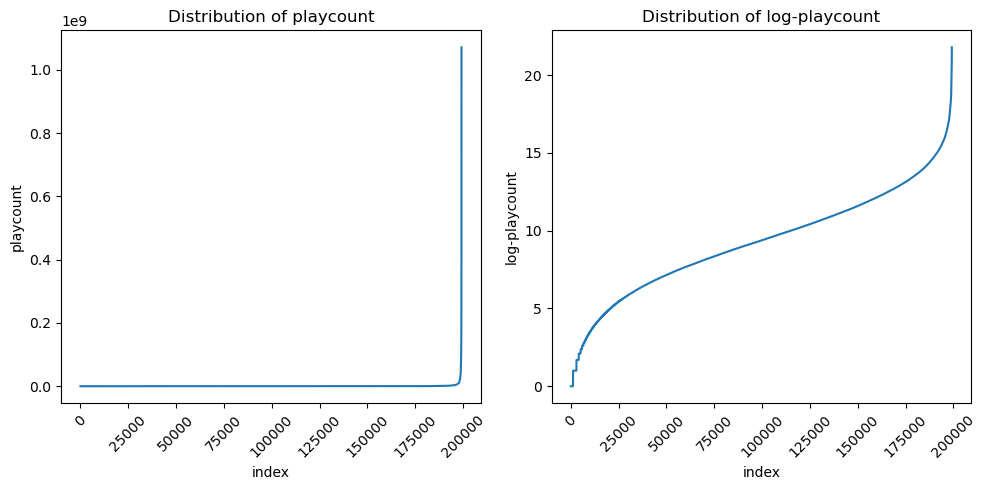

In [15]:
# Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(playcount)
ax1.set_title('Distribution of playcount')
ax1.set_xlabel('index')
ax1.set_ylabel('playcount')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(log_playcount)
ax2.set_title('Distribution of log-playcount')
ax2.set_xlabel('index')
ax2.set_ylabel('log-playcount')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/distr_playcount.png")
plt.show()

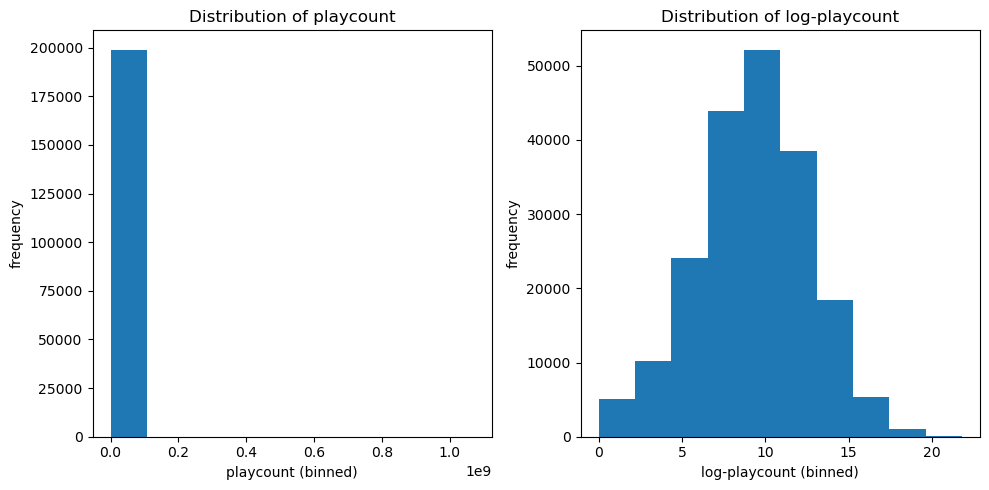

In [16]:
num_bins = 10

playcount_hist, playcount_bins = np.histogram(playcount, bins=num_bins)
log_playcount_hist, log_playcount_bins = np.histogram(log_playcount, bins=num_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(playcount_bins[:-1], playcount_hist, width=np.diff(playcount_bins), align='edge')
ax1.set_title('Distribution of playcount')
ax1.set_xlabel('playcount (binned)')
ax1.set_ylabel('frequency')

ax2.bar(log_playcount_bins[:-1], log_playcount_hist, width=np.diff(log_playcount_bins), align='edge')
ax2.set_title('Distribution of log-playcount')
ax2.set_xlabel('log-playcount (binned)')
ax2.set_ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_playcount.png')
plt.show()

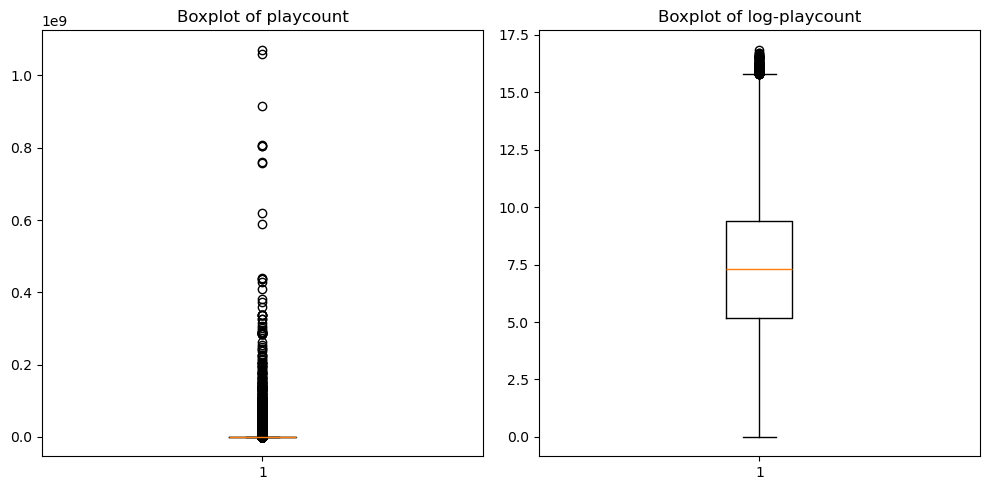

In [17]:
# Boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.boxplot(playcount)
ax1.set_title('Boxplot of playcount')

ax2.boxplot(log_listeners)
ax2.set_title('Boxplot of log-playcount')

plt.tight_layout()
plt.savefig("./img/boxplots_playcount.png")
plt.show()

In [18]:
# Stats
print("Playcount")
print(f"  Mean: {np.mean(playcount):.2f}")
print(f"    SD: {np.std(playcount):.2f}")
print(f"   Min: {np.min(playcount)}")
print(f"    Q1: {np.percentile(playcount, 25):.2f}")
print(f"    Q2: {np.percentile(playcount, 50):.2f}")
print(f"    Q3: {np.percentile(playcount, 75):.2f}")
print(f"   Max: {np.max(playcount)}")

print()

print("Log-Playcount")
print(f"  Mean: {np.mean(log_playcount):.2f}")
print(f"    SD: {np.std(log_playcount):.2f}")
print(f"   Min: {np.min(log_playcount)}")
print(f"    Q1: {np.percentile(log_playcount, 25):.2f}")
print(f"    Q2: {np.percentile(log_playcount, 50):.2f}")
print(f"    Q3: {np.percentile(log_playcount, 75):.2f}")
print(f"   Max: {np.max(log_playcount)}")

Playcount
  Mean: 522470.00
    SD: 8601385.70
   Min: 0
    Q1: 465.00
    Q2: 4315.00
    Q3: 38465.50
   Max: 1071161796

Log-Playcount
  Mean: 9.28
    SD: 3.35
   Min: 0.0
    Q1: 7.14
    Q2: 9.37
    Q3: 11.56
   Max: 21.792009687030106


#### Ended

In [53]:
query = "match (n:Artist) return n.ended as e;" 
ended = sorted([artist["e"] for artist in execute_query_return(driver, query)])
ended = np.array(ended)
log_ended = np.where(ended > 0, np.log(ended + 1), ended)

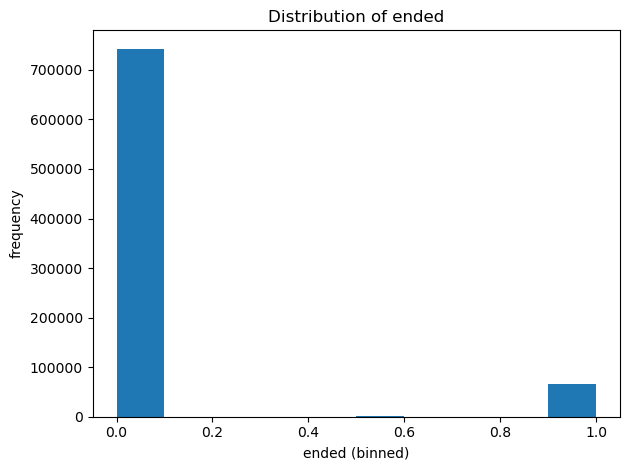

In [55]:
# Bar
num_bins = 10

ended_hist, ended_bins = np.histogram(ended, bins=num_bins)

plt.bar(ended_bins[:-1], ended_hist, width=np.diff(ended_bins), align='edge')
plt.title('Distribution of ended')
plt.xlabel('ended (binned)')
plt.ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_ended.png')
plt.show()

In [56]:
# Stats
print("Ended")
print(f"  Mean: {np.mean(ended):.2f}")
print(f"    SD: {np.std(ended):.2f}")
print(f"   Min: {np.min(ended)}")
print(f"    Q1: {np.percentile(ended, 25):.2f}")
print(f"    Q2: {np.percentile(ended, 50):.2f}")
print(f"    Q3: {np.percentile(ended, 75):.2f}")
print(f"   Max: {np.max(ended)}")

Ended
  Mean: 0.08
    SD: 0.27
   Min: 0.0
    Q1: 0.00
    Q2: 0.00
    Q3: 0.00
   Max: 1.0


#### Begin dates

In [61]:
query = "match (n:Artist) unwind n.begin_dates as d with d where size(d) > 0 return d;" 
begin_dates = [artist["d"] for artist in execute_query_return(driver, query)]
begin_dates = np.sort(np.array(begin_dates).astype(int))

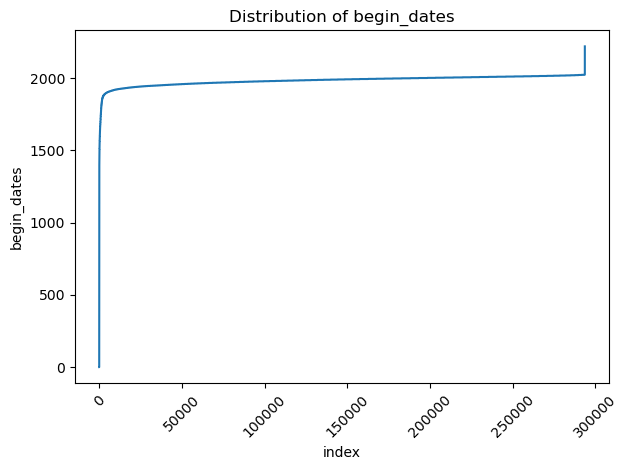

In [62]:
# Distribution
plt.plot(begin_dates)
plt.title('Distribution of begin_dates')
plt.xlabel('index')
plt.ylabel('begin_dates')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/distr_begin_dates.png")
plt.show()

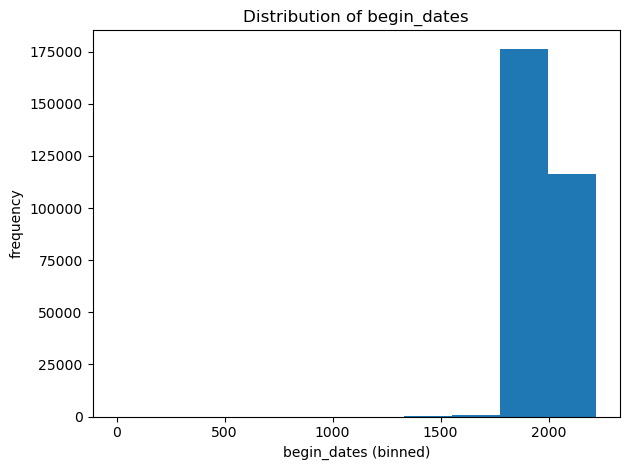

In [63]:
# Bar
num_bins = 10

begin_dates_hist, begin_dates_bins = np.histogram(begin_dates, bins=num_bins)

plt.bar(begin_dates_bins[:-1], begin_dates_hist, width=np.diff(begin_dates_bins), align='edge')
plt.title('Distribution of begin_dates')
plt.xlabel('begin_dates (binned)')
plt.ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_begin_dates.png')
plt.show()

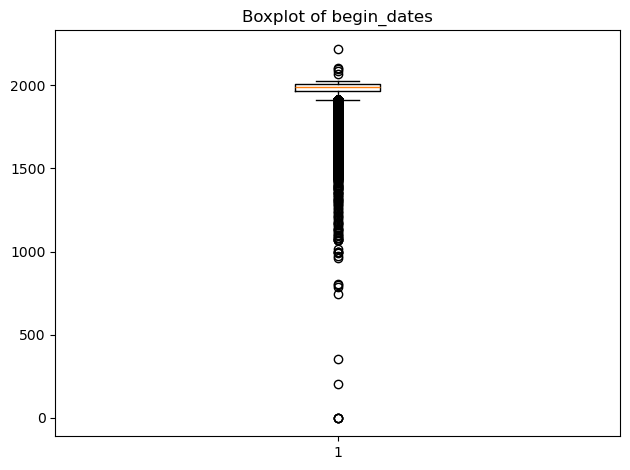

In [64]:
# Boxplot
plt.boxplot(begin_dates)
plt.title('Boxplot of begin_dates')

plt.tight_layout()
plt.savefig("./img/boxplot_begin_dates.png")
plt.show()

In [65]:
# Stats
print("Begin_dates")
print(f"  Mean: {np.mean(begin_dates):.2f}")
print(f"    SD: {np.std(begin_dates):.2f}")
print(f"   Min: {np.min(begin_dates)}")
print(f"    Q1: {np.percentile(begin_dates, 25):.2f}")
print(f"    Q2: {np.percentile(begin_dates, 50):.2f}")
print(f"    Q3: {np.percentile(begin_dates, 75):.2f}")
print(f"   Max: {np.max(begin_dates)}")

Begin_dates
  Mean: 1983.13
    SD: 38.25
   Min: 0
    Q1: 1969.00
    Q2: 1991.00
    Q3: 2006.00
   Max: 2220


#### Begin dates

In [67]:
query = "match (n:Artist) unwind n.end_dates as d with d where size(d) > 0 return d;" 
end_dates = [artist["d"] for artist in execute_query_return(driver, query)]
end_dates = np.sort(np.array(begin_dates).astype(int))

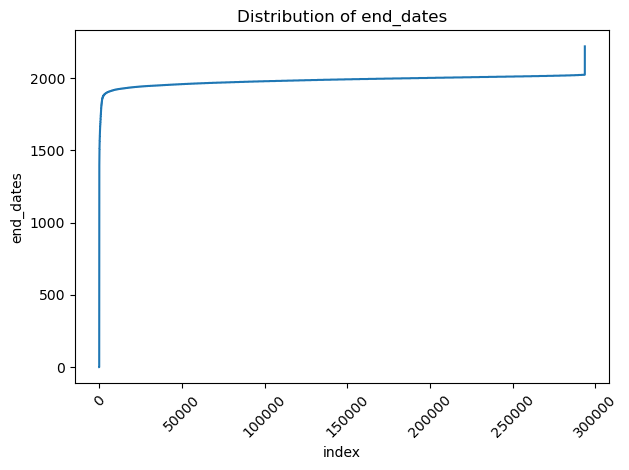

In [68]:
# Distribution
plt.plot(end_dates)
plt.title('Distribution of end_dates')
plt.xlabel('index')
plt.ylabel('end_dates')
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("./img/distr_end_dates.png")
plt.show()

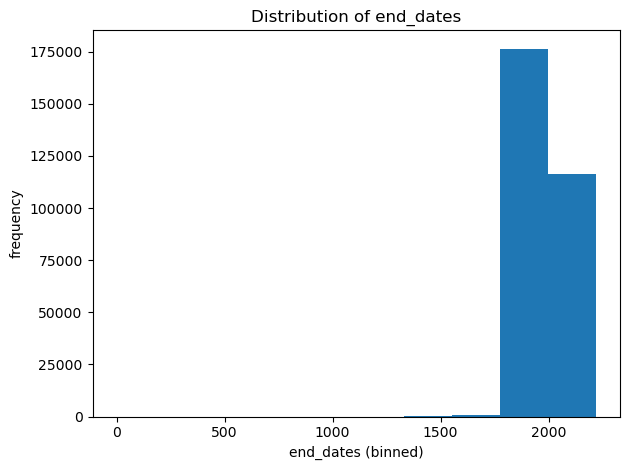

In [71]:
# Bar
num_bins = 10

end_dates_hist, end_dates_bins = np.histogram(end_dates, bins=num_bins)

plt.bar(end_dates_bins[:-1], end_dates_hist, width=np.diff(end_dates_bins), align='edge')
plt.title('Distribution of end_dates')
plt.xlabel('end_dates (binned)')
plt.ylabel('frequency')

plt.tight_layout()
plt.savefig('./img/bars_end_dates.png')
plt.show()

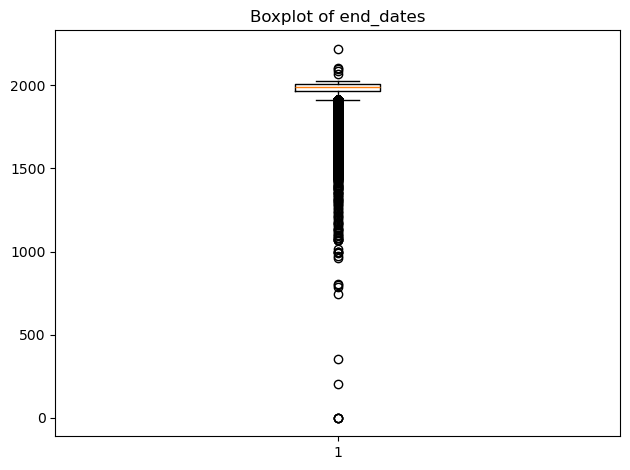

In [72]:
# Boxplot
plt.boxplot(end_dates)
plt.title('Boxplot of end_dates')

plt.tight_layout()
plt.savefig("./img/boxplot_end_dates.png")
plt.show()

In [74]:
# Stats
print("End_dates")
print(f"  Mean: {np.mean(end_dates):.2f}")
print(f"    SD: {np.std(end_dates):.2f}")
print(f"   Min: {np.min(end_dates)}")
print(f"    Q1: {np.percentile(end_dates, 25):.2f}")
print(f"    Q2: {np.percentile(end_dates, 50):.2f}")
print(f"    Q3: {np.percentile(end_dates, 75):.2f}")
print(f"   Max: {np.max(end_dates)}")

End_dates
  Mean: 1983.13
    SD: 38.25
   Min: 0
    Q1: 1969.00
    Q2: 1991.00
    Q3: 2006.00
   Max: 2220


#### Gender

In [80]:
query = "match (n:Artist) return n.gender_1 as g1, n.gender_2 as g2, n.gender_3 as g3, n.gender_4 as g4, n.gender_5 as g5;" 
genders = np.array([
    np.array([artist["g1"], artist["g2"], artist["g3"], artist["g4"], artist["g5"]])
    for artist in execute_query_return(driver, query)
])

In [96]:
# Number of artists for each gender
np.sum(genders, axis=0)

array([219204,  68607,    768,    588,    636])

In [97]:
# Artists with more than one gender
genders[np.sum(genders, axis=1) > 1].shape[0]

412

In [98]:
# Out of those, which are "other" and "non-binary" at the same time
genders[genders[:, 2] & genders[:, 4]].shape[0]

13

#### Type

In [101]:
query = "match (n:Artist) return n.type_1 as t1, n.type_2 as t2, n.type_3 as t3, n.type_4 as t4, n.type_5 as t5, n.type_6 as t6;" 
types = np.array([
    np.array([artist["t1"], artist["t2"], artist["t3"], artist["t4"], artist["t5"], artist["t6"]])
    for artist in execute_query_return(driver, query)
])

In [102]:
# Number of artists for each type
np.sum(types, axis=0)

array([336633, 335818,   1521,   4088,   4459,   3142])

In [103]:
# Artists with more than one type
types[np.sum(types, axis=1) > 1].shape[0]

3348

In [104]:
# Out of those, which are "group" and ("orchestra" or "band") at the same time
types[types[:, 1] & (types[:, 4] | types[:, 5])].shape[0]

16

## Cleanup

In [ ]:
driver.close()